In [33]:
# 설명: path/pre 안에 이미지들을 넣고 시작하면 알아서 split, 어그멘테이션, 개지랄 시작됨

import shutil
import os
import cv2
import random
from tqdm import tqdm
import numpy as np
from PIL import Image
import torch
import torch.nn as nn
from torch.utils.data import Dataset
from torchvision import transforms
from torchvision.models import resnet152
from torch.utils.data import DataLoader
import torch.optim as optim
from torch.optim.lr_scheduler import ReduceLROnPlateau

path = 'D:/datasets/J_AngleDetect'

In [34]:
# 데이터 Split

val_goal, test_goal = 100, 100

os.makedirs('{}/1st/train/images'.format(path), exist_ok = True)
os.makedirs('{}/1st/train/labels'.format(path), exist_ok = True)
os.makedirs('{}/1st/val/images'.format(path), exist_ok = True)
os.makedirs('{}/1st/val/labels'.format(path), exist_ok = True)
os.makedirs('{}/1st/test/images'.format(path), exist_ok = True)
os.makedirs('{}/1st/test/labels'.format(path), exist_ok = True)

img_list = os.listdir('{}/pre'.format(path))
random.shuffle(img_list)
val_cnt, test_cnt = 0, 0
while True:
    if len(img_list) == 0: break
    if val_cnt < val_goal:
        mode = 'val'
        val_cnt += 1
    elif test_cnt < test_goal:
        mode = 'test'
        test_cnt += 1
    else: mode = 'train'
    only_name = img_list[-1].split('.')[0]
    from_path = '{}/pre/{}.png'.format(path, only_name)
    to_path = '{}/1st/{}/images/{}_split.png'.format(path, mode, only_name)
    shutil.copy(from_path, to_path)
    del img_list[-1]

In [35]:
# 레이블 생성

def img_rotate(img, angle):
    # 이미지의 크기를 잡고 이미지의 중심을 계산합니다.
    (h, w) = img.shape[:2]
    (cX, cY) = (w // 2, h // 2)
    # 이미지의 중심을 중심으로 이미지를  angle도 회전합니다.
    M = cv2.getRotationMatrix2D((cX, cY), angle, 1.0)
    rotated = cv2.warpAffine(img, M, (w, h))
    return rotated

folder_list = os.listdir('{}/1st'.format(path))
name_cnt = 0
for folder in folder_list:
    img_list = os.listdir('{}/1st/{}/images'.format(path, folder))
    print('레이블 생성 중...')
    for img_name in tqdm(img_list):
        img = cv2.imread('{}/1st/{}/images/{}'.format(path, folder, img_name))
        if folder == 'train': for_cnt = 10
        else: for_cnt = 1
        for _ in range(for_cnt):
            rand_no = random.random()
            angle = (rand_no * 90) - 45
            with open('{}/1st/{}/labels/{}.txt'.format(path, folder, name_cnt), 'w') as f:
                f.write('{}'.format(angle))
            img = img_rotate(img, angle)
            cv2.imwrite('{}/1st/{}/images/{}.png'.format(path, folder, name_cnt), img)
            name_cnt += 1
    print('이미지 삭제 중...')
    for img_name in tqdm(img_list):
        os.remove('{}/1st/{}/images/{}'.format(path, folder, img_name))

레이블 생성 중...


100%|███████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 254.59it/s]


이미지 삭제 중...


100%|██████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 8971.20it/s]


레이블 생성 중...


100%|██████████████████████████████████████████████████████████████████████████████| 3260/3260 [01:09<00:00, 47.10it/s]


이미지 삭제 중...


100%|████████████████████████████████████████████████████████████████████████████| 3260/3260 [00:00<00:00, 4733.31it/s]


레이블 생성 중...


100%|███████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 196.14it/s]


이미지 삭제 중...


100%|██████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 5882.78it/s]


In [36]:
# Data Loader

class CustomDataset(Dataset):
    def __init__(self, image_folder, label_folder, transform=None):
        self.image_folder = image_folder
        self.label_folder = label_folder
        self.transform = transform
        self.image_files = os.listdir(image_folder)

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, index):
        image_name = self.image_files[index]
        image_path = os.path.join(self.image_folder, image_name)
        label_path = os.path.join(self.label_folder, f"{os.path.splitext(image_name)[0]}.txt")

        image = Image.open(image_path).convert("RGB")
        image = self.transform(image).float()
        with open(label_path, "r") as file:
            label = float(file.readline().strip())

        return image, label

# 전처리 변환 정의
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # 이미지 크기 조정
    transforms.ToTensor(),  # 텐서로 변환
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # 정규화
])

batch_size = 32

# CustomDataset 인스턴스 생성
train_data = CustomDataset('{}/1st/train/images'.format(path), '{}/1st/train/labels'.format(path), transform=transform)
train_dataloader = DataLoader(train_data, batch_size = batch_size, shuffle = True)

val_data = CustomDataset('{}/1st/val/images'.format(path), '{}/1st/val/labels'.format(path), transform=transform)
val_dataloader = DataLoader(val_data, batch_size = batch_size, shuffle = True)

test_data = CustomDataset('{}/1st/test/images'.format(path), '{}/1st/test/labels'.format(path), transform=transform)
test_dataloader = DataLoader(test_data, batch_size = 1, shuffle = False)

In [37]:
os.makedirs('{}/1st/weights'.format(path), exist_ok = True)

# GPU 사용이 가능하면 GPU로 모델 이동
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# 하이퍼파라미터 설정
learning_rate = 0.00001
num_epochs = 100

# ResNet 모델 불러오기
model = resnet152(pretrained = True)

# ResNet의 마지막 레이어 변경
num_features = model.fc.in_features
model.fc = nn.Linear(num_features, 1)  # 실수 출력을 위한 Linear 레이어

model = model.float().to(device)

# 손실 함수 정의
criterion = nn.MSELoss()

# 옵티마이저 정의
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# 스케줄러
scheduler = ReduceLROnPlateau(optimizer, mode='min', patience=3, factor=0.1, verbose=True)

# 학습
best_loss = 99999
early_cnt = 0
for epoch in range(num_epochs):
    # 훈련 모드 설정
    model.train()
    
    train_loss = 0.0
    for images, labels in tqdm(train_dataloader):
        # GPU로 데이터 이동
        images = images.to(device)
        labels = labels.to(device).float()

        # 순전파
        outputs = model(images)
        loss = criterion(outputs, labels.unsqueeze(1))

        # 역전파 및 가중치 갱신
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # 훈련 손실 누적
        train_loss += loss.item() * images.size(0)
    
    # 검증 모드 설정
    model.eval()

    val_loss = 0.0
    with torch.no_grad():
        for images, labels in val_dataloader:
            # GPU로 데이터 이동
            images = images.to(device)
            labels = labels.to(device)

            # 순전파
            outputs = model(images)
            loss = criterion(outputs, labels.unsqueeze(1))

            # 검증 손실 누적
            val_loss += loss.item() * images.size(0)
    
    # 에폭별 평균 손실 계산
    train_loss /= len(train_data)
    val_loss /= len(val_data)
    
    # 스케줄러 업데이트
    scheduler.step(val_loss)
    
    if val_loss < best_loss:
        early_cnt = 0
        print('Loss 갱신, 모델 저장')
        torch.save(model.state_dict(), '{}/1st/weights/{}.pt'.format(path, epoch))
        best_loss = val_loss
    else:
        early_cnt += 1
    if early_cnt == 10:
        print('10번 연속 발전이 없었음. 학습 종료')
        break
    # 결과 출력
    print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}")

100%|██████████████████████████████████████████████████████████████████████████████| 1019/1019 [11:19<00:00,  1.50it/s]


Loss 갱신, 모델 저장
Epoch [1/100], Train Loss: 619.4655, Val Loss: 173.2335


100%|██████████████████████████████████████████████████████████████████████████████| 1019/1019 [09:26<00:00,  1.80it/s]


Loss 갱신, 모델 저장
Epoch [2/100], Train Loss: 481.5410, Val Loss: 88.2024


100%|██████████████████████████████████████████████████████████████████████████████| 1019/1019 [09:25<00:00,  1.80it/s]


Loss 갱신, 모델 저장
Epoch [3/100], Train Loss: 379.3693, Val Loss: 37.9392


100%|██████████████████████████████████████████████████████████████████████████████| 1019/1019 [09:21<00:00,  1.81it/s]


Loss 갱신, 모델 저장
Epoch [4/100], Train Loss: 313.9530, Val Loss: 37.6694


100%|██████████████████████████████████████████████████████████████████████████████| 1019/1019 [09:19<00:00,  1.82it/s]


Loss 갱신, 모델 저장
Epoch [5/100], Train Loss: 237.1843, Val Loss: 22.1756


100%|██████████████████████████████████████████████████████████████████████████████| 1019/1019 [09:17<00:00,  1.83it/s]


Epoch [6/100], Train Loss: 163.9486, Val Loss: 48.4669


100%|██████████████████████████████████████████████████████████████████████████████| 1019/1019 [09:19<00:00,  1.82it/s]


Epoch [7/100], Train Loss: 110.5672, Val Loss: 40.6010


100%|██████████████████████████████████████████████████████████████████████████████| 1019/1019 [09:16<00:00,  1.83it/s]


Epoch [8/100], Train Loss: 83.0902, Val Loss: 35.0780


100%|██████████████████████████████████████████████████████████████████████████████| 1019/1019 [09:17<00:00,  1.83it/s]


Loss 갱신, 모델 저장
Epoch [9/100], Train Loss: 71.1678, Val Loss: 22.0812


100%|██████████████████████████████████████████████████████████████████████████████| 1019/1019 [09:16<00:00,  1.83it/s]


Epoch [10/100], Train Loss: 60.5792, Val Loss: 43.0771


100%|██████████████████████████████████████████████████████████████████████████████| 1019/1019 [09:15<00:00,  1.83it/s]


Loss 갱신, 모델 저장
Epoch [11/100], Train Loss: 55.4777, Val Loss: 20.0812


100%|██████████████████████████████████████████████████████████████████████████████| 1019/1019 [09:16<00:00,  1.83it/s]


Loss 갱신, 모델 저장
Epoch [12/100], Train Loss: 51.1360, Val Loss: 18.1648


100%|██████████████████████████████████████████████████████████████████████████████| 1019/1019 [09:17<00:00,  1.83it/s]


Epoch [13/100], Train Loss: 46.8132, Val Loss: 33.2216


100%|██████████████████████████████████████████████████████████████████████████████| 1019/1019 [09:19<00:00,  1.82it/s]


Epoch [14/100], Train Loss: 42.2137, Val Loss: 27.8591


100%|██████████████████████████████████████████████████████████████████████████████| 1019/1019 [09:16<00:00,  1.83it/s]


Epoch [15/100], Train Loss: 37.5296, Val Loss: 26.5942


100%|██████████████████████████████████████████████████████████████████████████████| 1019/1019 [09:17<00:00,  1.83it/s]


Epoch    16: reducing learning rate of group 0 to 1.0000e-06.
Epoch [16/100], Train Loss: 34.4407, Val Loss: 39.3461


100%|██████████████████████████████████████████████████████████████████████████████| 1019/1019 [09:16<00:00,  1.83it/s]


Epoch [17/100], Train Loss: 25.3038, Val Loss: 29.8397


100%|██████████████████████████████████████████████████████████████████████████████| 1019/1019 [09:16<00:00,  1.83it/s]


Epoch [18/100], Train Loss: 20.9626, Val Loss: 31.2356


100%|██████████████████████████████████████████████████████████████████████████████| 1019/1019 [09:16<00:00,  1.83it/s]


Epoch [19/100], Train Loss: 18.8841, Val Loss: 24.0114


100%|██████████████████████████████████████████████████████████████████████████████| 1019/1019 [09:17<00:00,  1.83it/s]


Epoch    20: reducing learning rate of group 0 to 1.0000e-07.
Epoch [20/100], Train Loss: 16.1486, Val Loss: 25.8310


100%|██████████████████████████████████████████████████████████████████████████████| 1019/1019 [09:18<00:00,  1.82it/s]


Epoch [21/100], Train Loss: 15.0661, Val Loss: 20.7025


100%|██████████████████████████████████████████████████████████████████████████████| 1019/1019 [09:16<00:00,  1.83it/s]


10번 연속 발전이 없었음. 학습 종료


In [39]:
os.makedirs('{}/1st/result_images'.format(path), exist_ok = True)

def img_rotate(img, angle):
    # 이미지의 크기를 잡고 이미지의 중심을 계산합니다.
    (h, w) = img.shape[:2]
    (cX, cY) = (w // 2, h // 2)
    # 이미지의 중심을 중심으로 이미지를  angle도 회전합니다.
    M = cv2.getRotationMatrix2D((cX, cY), angle, 1.0)
    rotated = cv2.warpAffine(img, M, (w, h))
    return rotated

# weight 부르기
weights = torch.load('{}/1st/weights/11.pt'.format(path))
model.load_state_dict(weights)
model.eval()

img_list = os.listdir('{}/1st/test/images'.format(path))
with torch.no_grad():
    cnt = 0
    for images, labels in test_dataloader:
        # GPU로 데이터 이동
        images = images.to(device)
        labels = labels.to(device)

        # 순전파
        outputs = model(images)
        angle = outputs.item()
    
        # GPU에서 이미지를 CPU로 이동하고 NumPy 배열로 변환
        images_cpu = images.cpu().numpy()

        # 이미지의 채널 순서 변경 (PyTorch: [batch_size, channels, height, width] -> OpenCV: [height, width, channels])
        image_cpu = np.transpose(images_cpu, (0, 2, 3, 1))[0]

        # NumPy 배열을 OpenCV 이미지로 변환
        image = np.uint8(image_cpu * 255)  # 이미지의 값 범위를 0~255로 변환 (전처리를 역으로 적용)
        image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)  # 이미지의 채널 순서 변경 (RGB -> BGR)
        
        img_show = cv2.imread('{}/1st/test/images/{}'.format(path, img_list[cnt]))
        image_turn = img_rotate(img_show, angle * -1)
        img_show = cv2.putText(img_show, '{} degree'.format(round(angle, 2)), (10, 30), cv2.FONT_HERSHEY_PLAIN, 1.2, (0, 0, 255), 1, cv2.LINE_AA)
        save_img = cv2.hconcat([img_show, image_turn])
        
        # 이미지 저장
        cv2.imwrite('{}/1st/result_images/{}'.format(path, img_list[cnt]), save_img)
        cv2.imshow('test', save_img)
        cv2.waitKey(1)
        
        cnt += 1
cv2.destroyAllWindows()

# 2차 학습(각도를 + - 10도만 해서 고도화)

In [ ]:
# 데이터셋 생성.
path2 = '{}/2nd'
os.makedirs(path2, exist_ok = True)

path = 'D:/datasets/J_AngleDetect'
os.makedirs('{}/images'.format(path), exist_ok = True)
os.makedirs('{}/labels'.format(path), exist_ok = True)

def img_rotate(img, angle):
    # 이미지의 크기를 잡고 이미지의 중심을 계산합니다.
    (h, w) = img.shape[:2]
    (cX, cY) = (w // 2, h // 2)
    # 이미지의 중심을 중심으로 이미지를  angle도 회전합니다.
    M = cv2.getRotationMatrix2D((cX, cY), angle, 1.0)
    rotated = cv2.warpAffine(img, M, (w, h))
    return rotated

img_list = os.listdir('{}/pre'.format(path))
for img_name in tqdm(img_list):
    only_name = img_name.split('.')[0]
    img = cv2.imread('{}/pre/{}'.format(path, img_name))
    # - 45 ~ 45 사이의 값을 랜덤으로 출력
    rand_no = int((random.random() * 90) - 45)
    with open('{}/labels/{}.txt'.format(path, only_name), 'w') as f:
        f.write('{}'.format(rand_no))
    img = img_rotate(img, rand_no)
    cv2.imwrite('{}/images/{}'.format(path, img_name), img)
    cv2.imshow('test', img)
    cv2.waitKey(1)
cv2.destroyAllWindows()

# 사진들

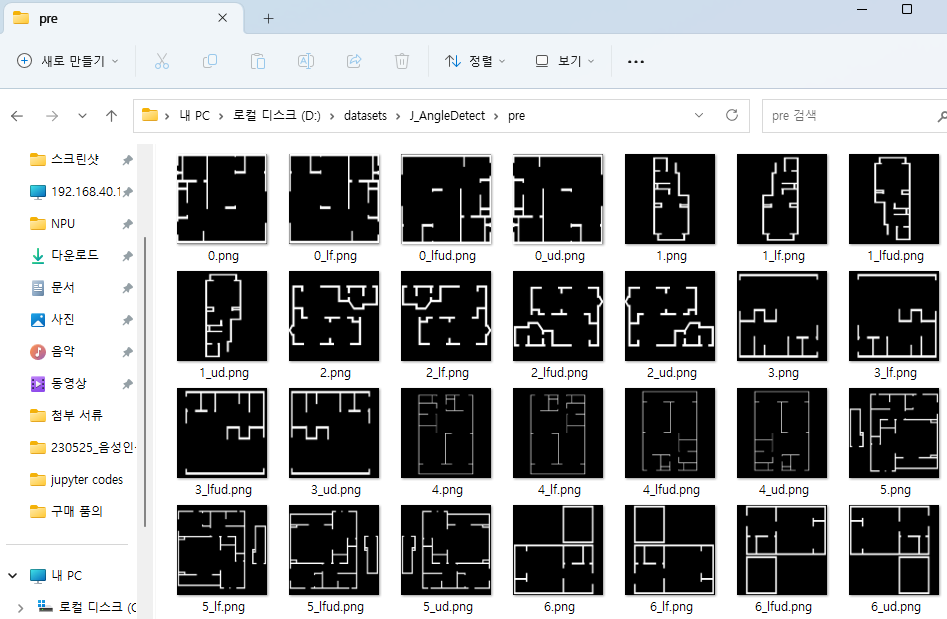
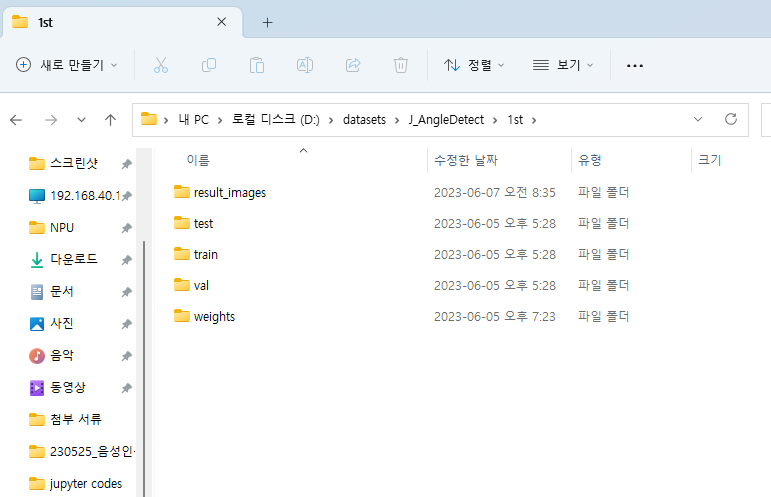
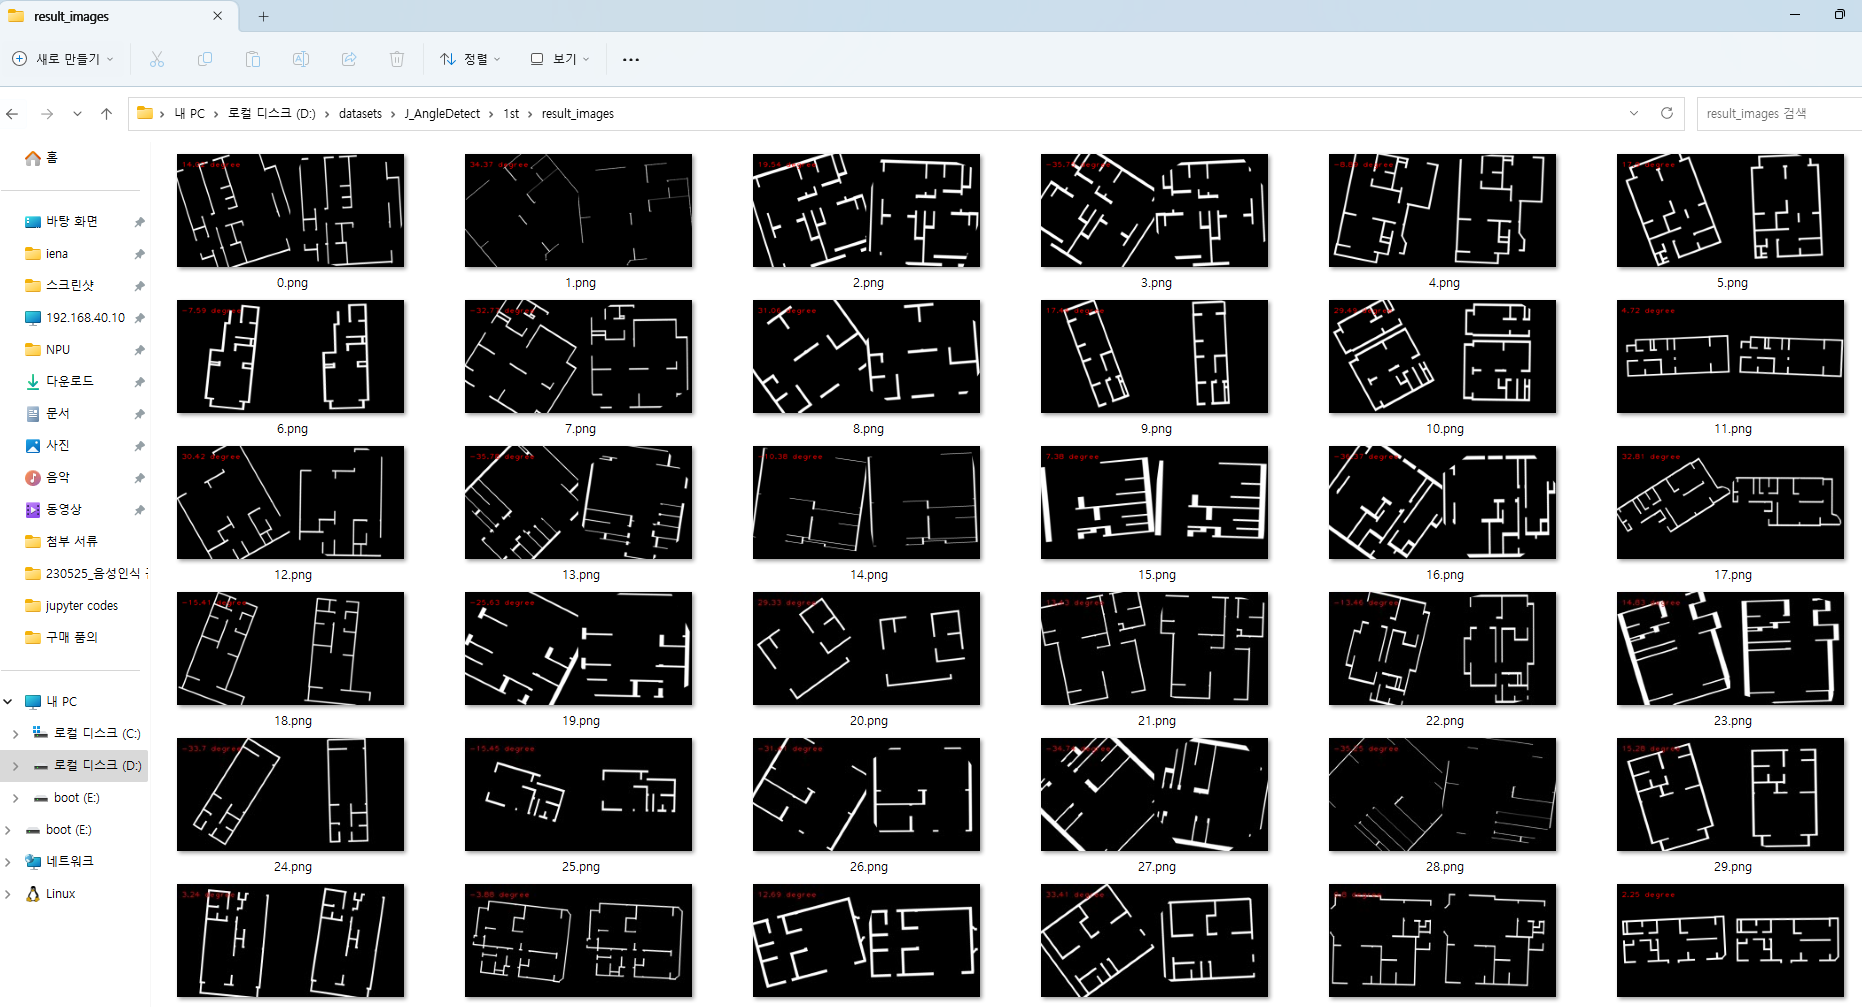
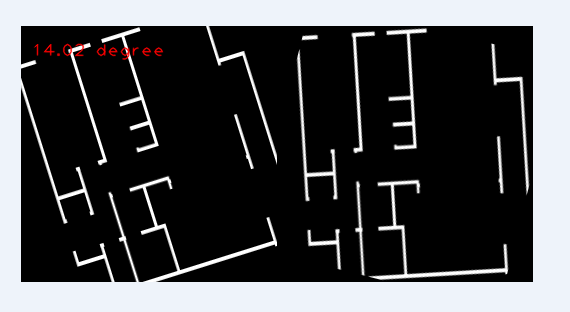
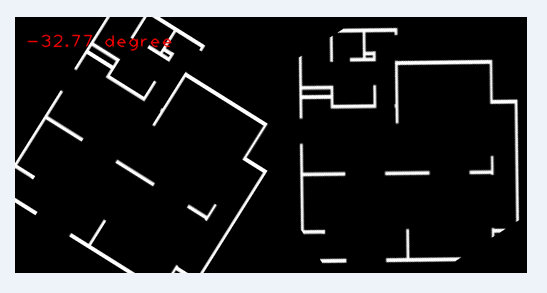
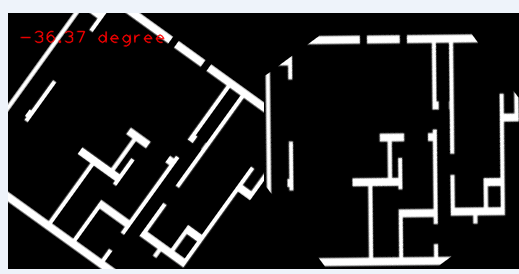
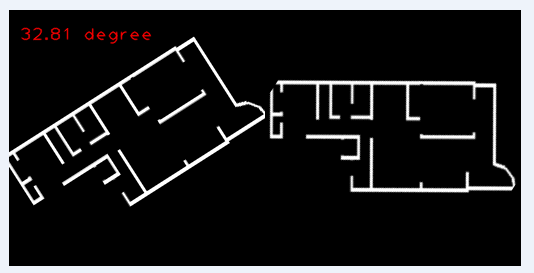
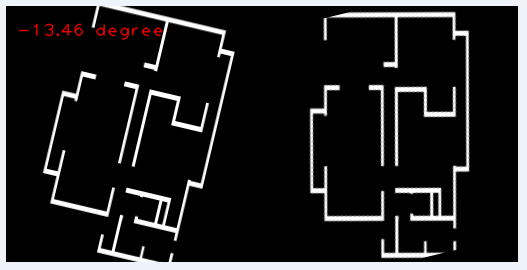
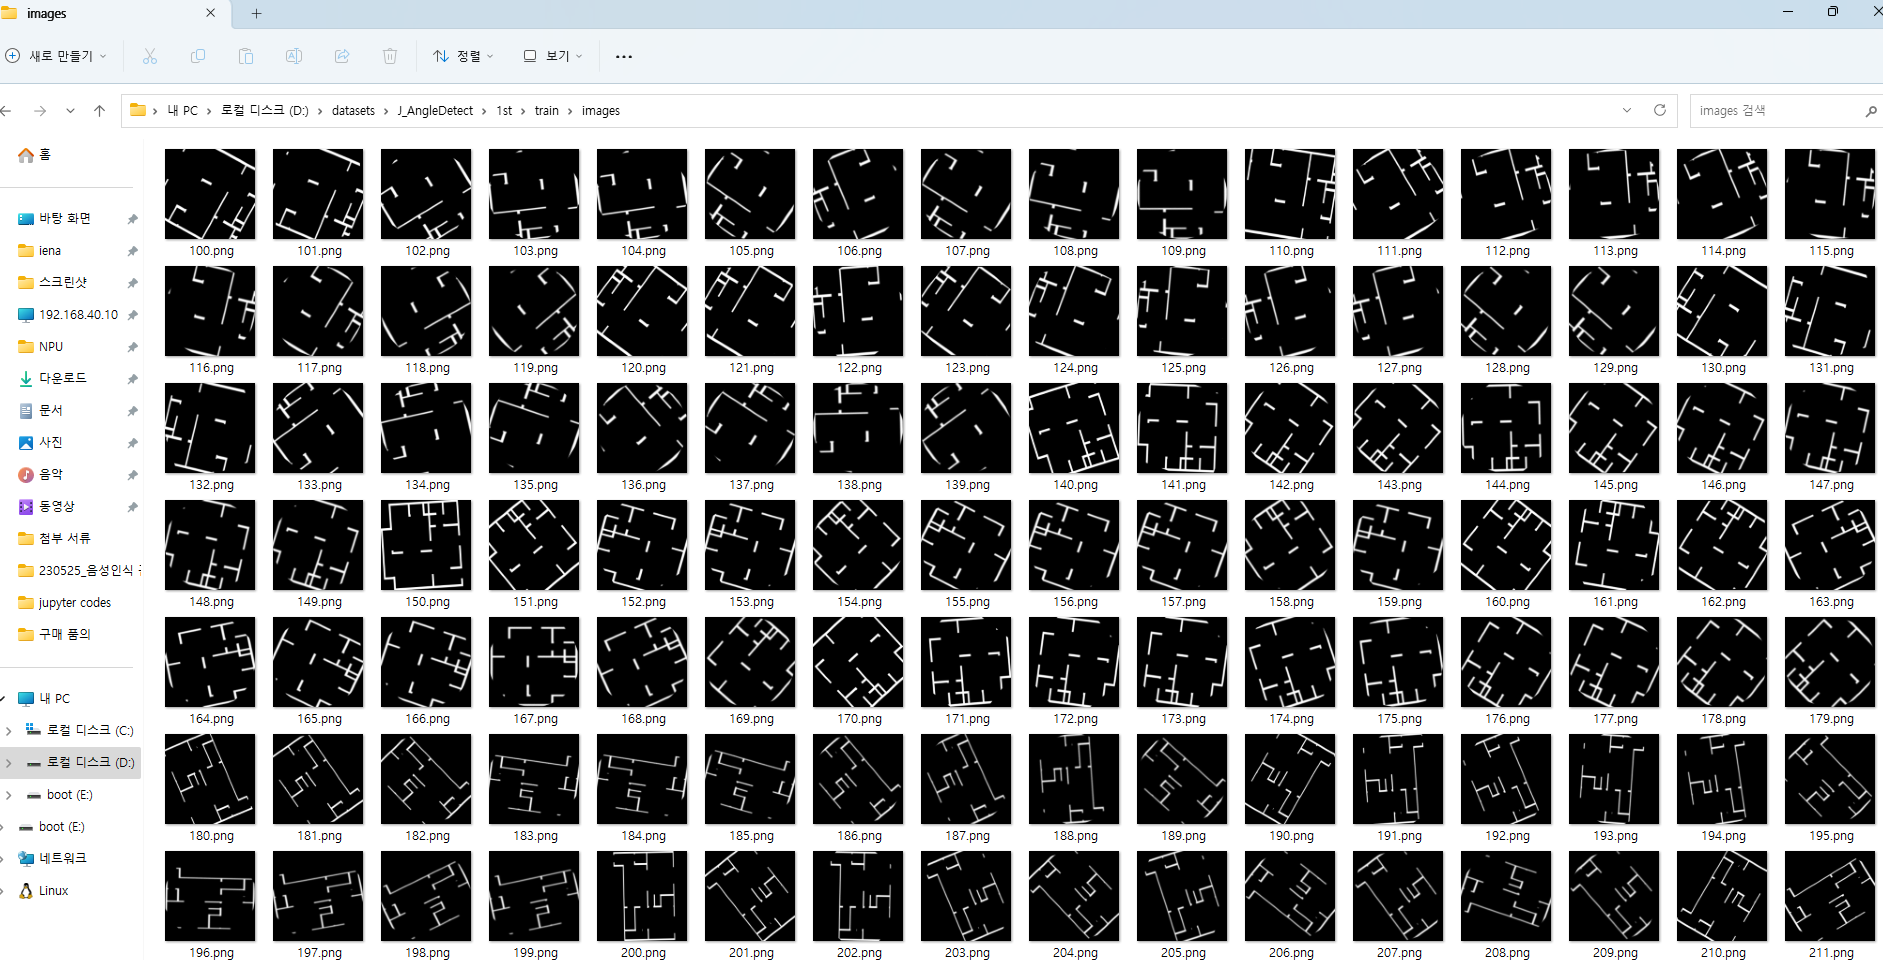
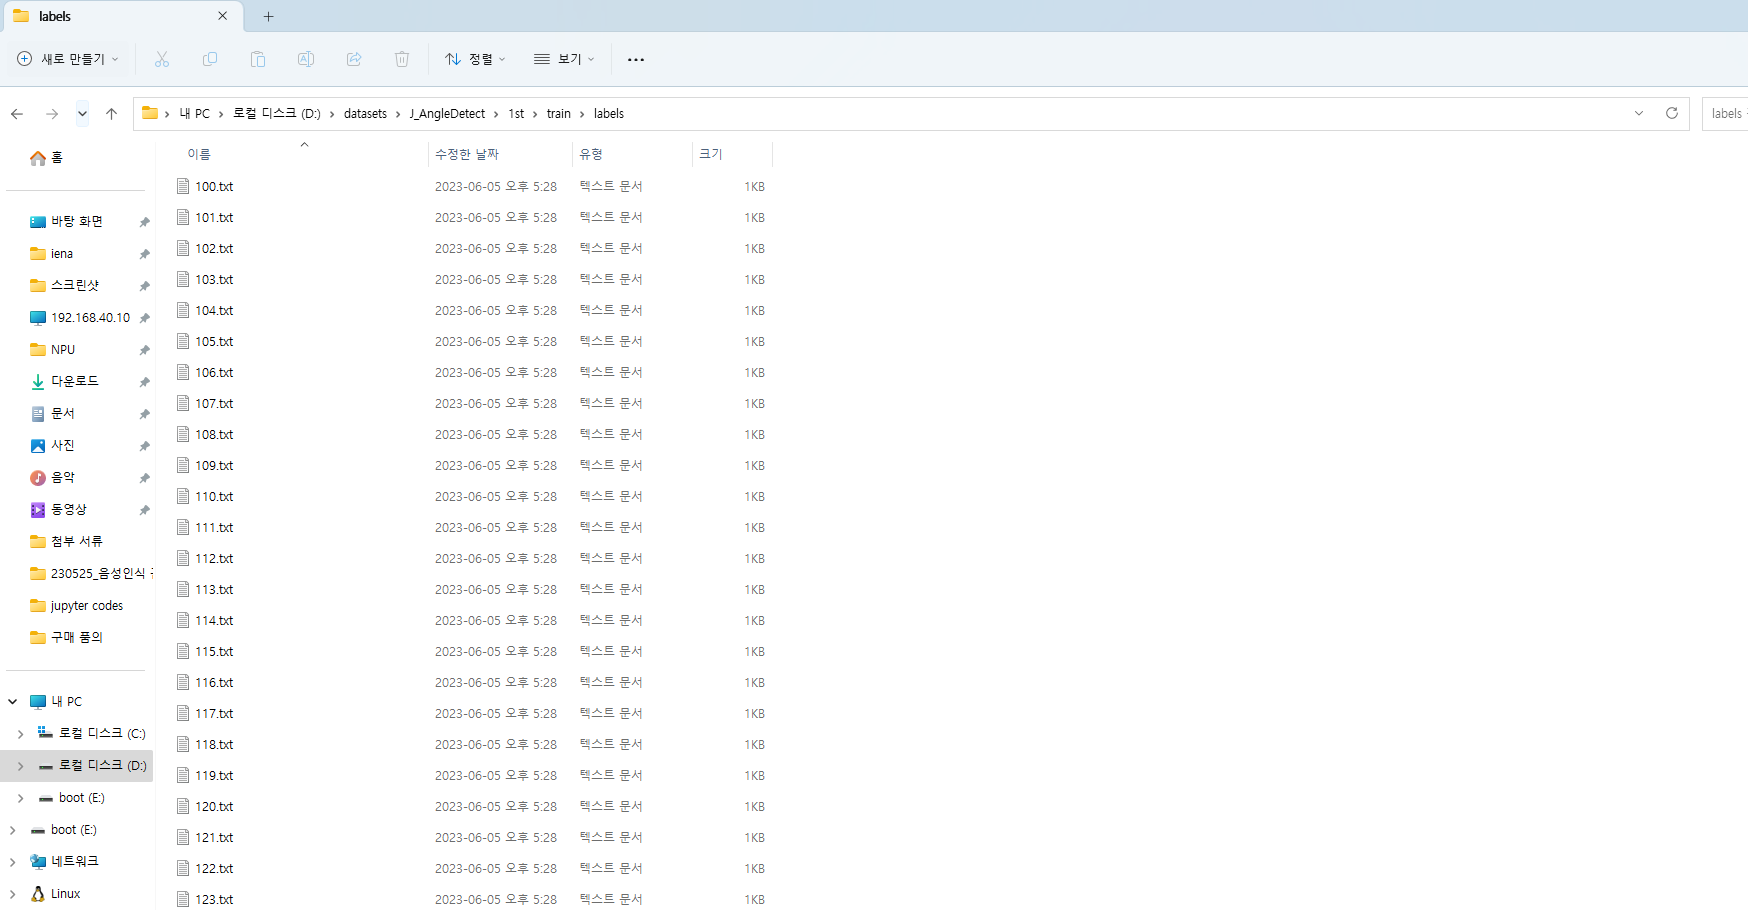
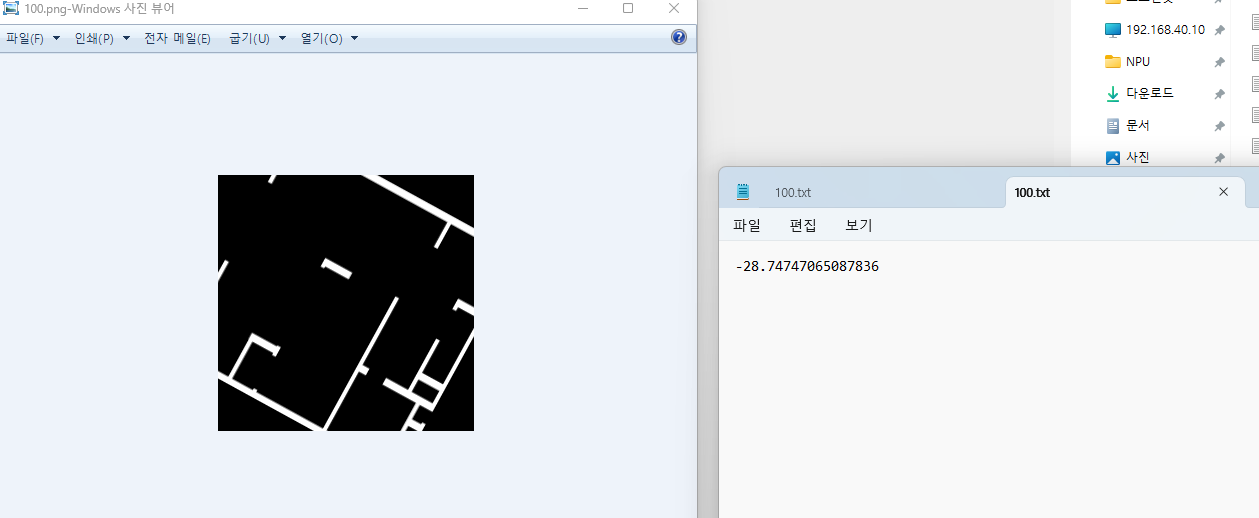
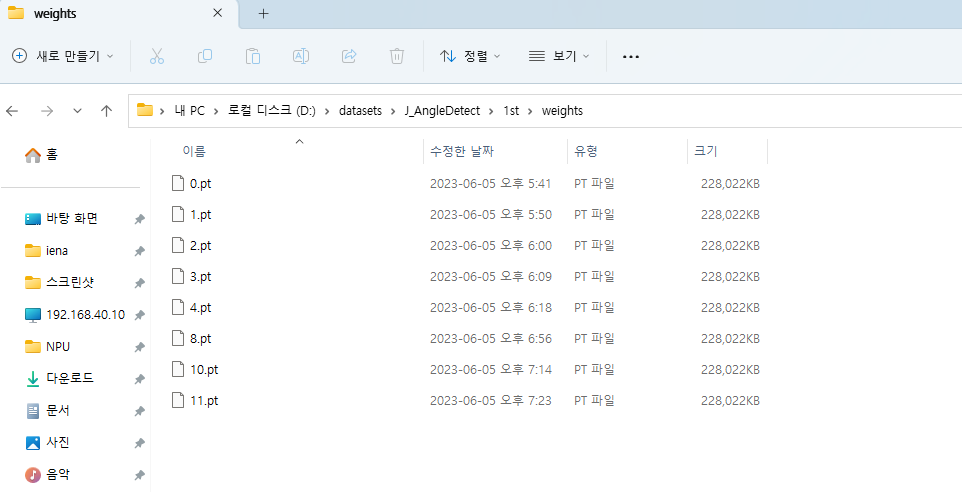